In [1]:
import pandas as pd
data = pd.read_csv('final_data.csv')

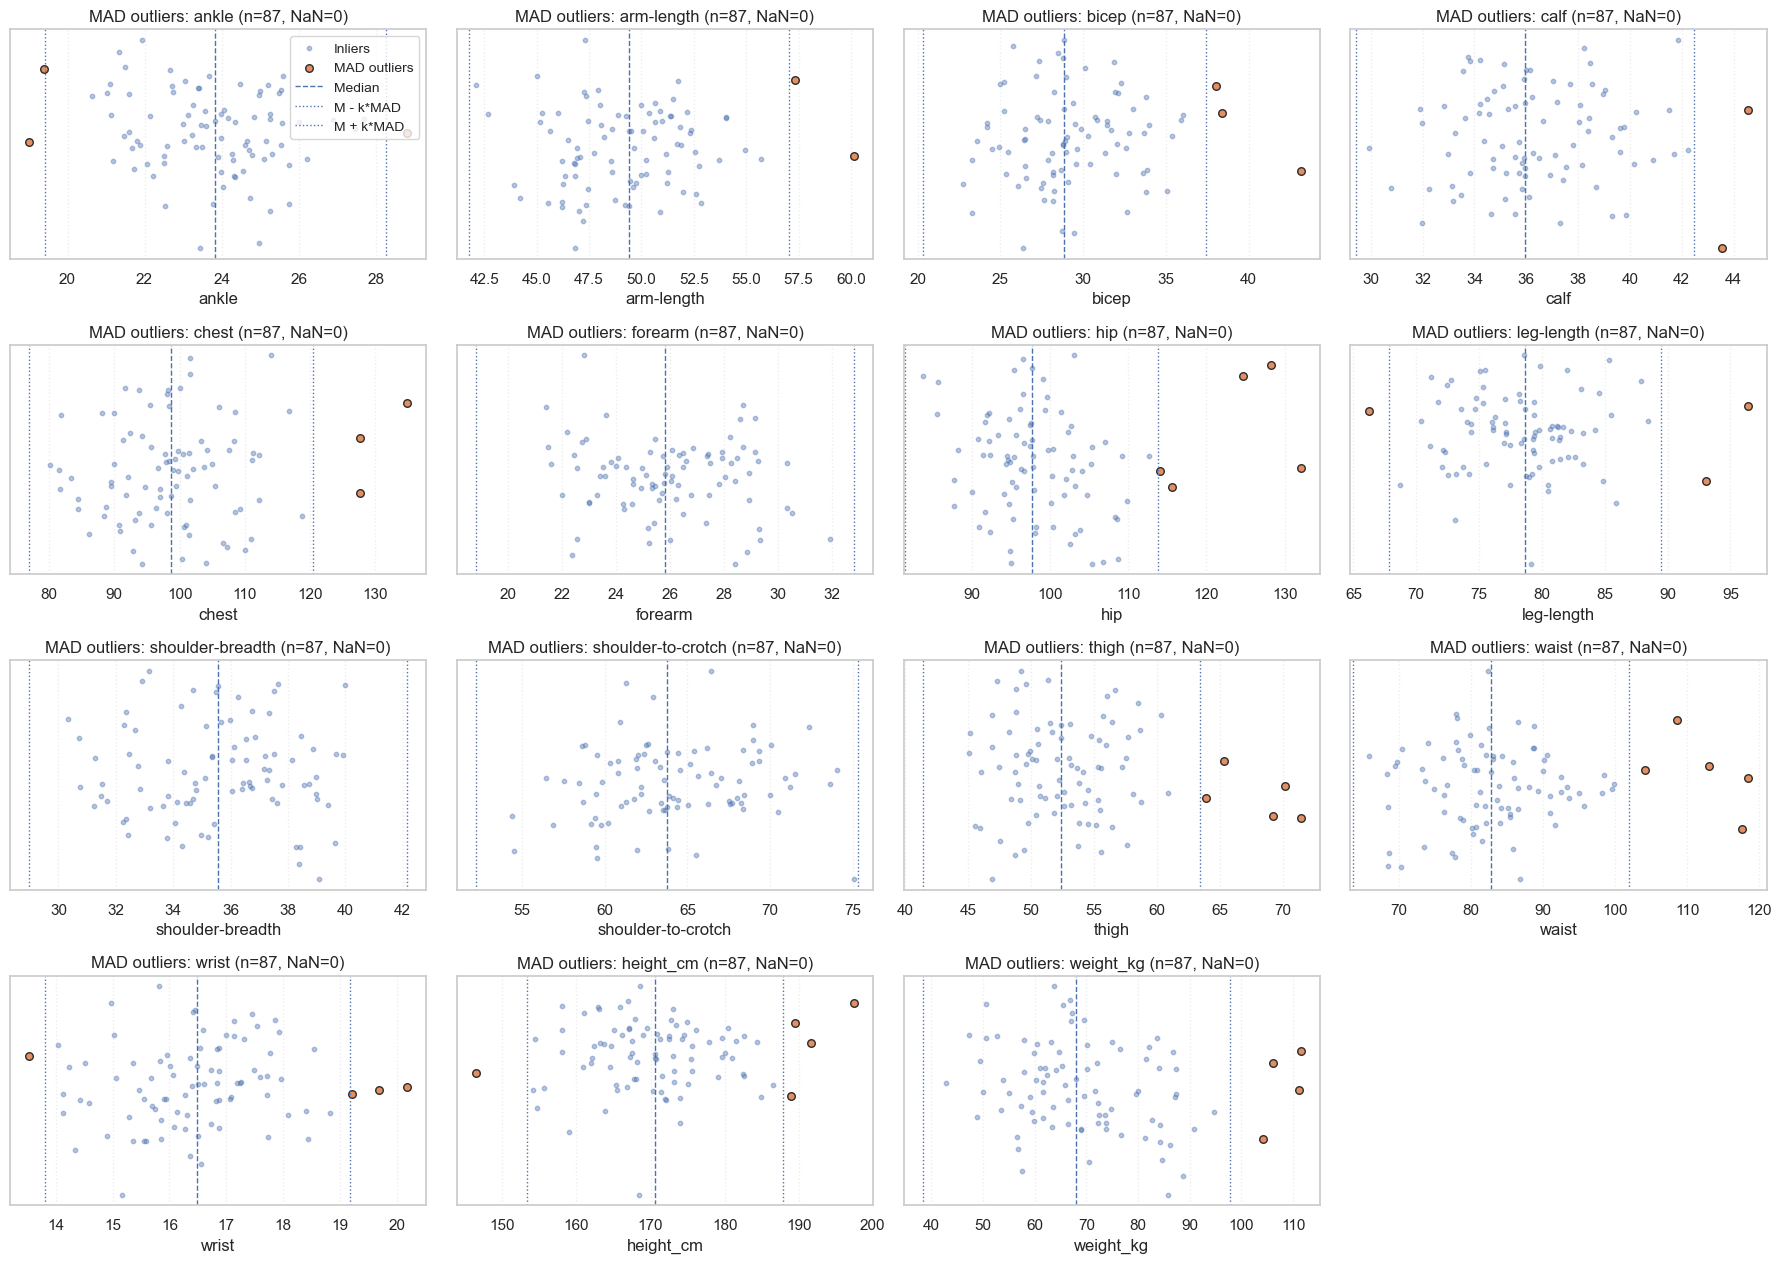

In [2]:
import math                          # for computing rows if you ever change the grid width
import numpy as np                   # to help flatten axes arrays
import pandas as pd                  # for numeric coercion / NA handling
import matplotlib.pyplot as plt      # plotting
import seaborn as sns                # optional: for general style

sns.set(style="whitegrid")

# --- your columns (keep only those that actually exist in `data`) ---
cols = ['ankle','arm-length','bicep','calf','chest','forearm','hip',
        'leg-length','shoulder-breadth','shoulder-to-crotch','thigh','waist',
        'wrist','height_cm','weight_kg']
cols = [c for c in cols if c in data.columns]        # drop any names not present

if not cols:
    raise ValueError("None of the requested columns exist in 'data'.")

# --- layout: 4 plots per row -> 4×4 grid for 16 columns ---
plots_per_row = 4                                     # change to 3 for a 3×N layout, etc.
n = len(cols)                                         # number of variables to plot
nrows = math.ceil(n / plots_per_row)                  # rows required
ncols = plots_per_row                                 # columns per row

# --- MAD tuning parameter (k) ---
k = 3.5  # common choices: 3 or 3.5

# dictionary to store outlier indices per column
mad_outliers = {}

# --- create figure & axes ---
fig, axes = plt.subplots(nrows, ncols, figsize=(4.5 * ncols, 3.2 * nrows))
axes = np.atleast_1d(axes).ravel()                    # flatten to 1D list of axes

# --- MAD-based outlier detection and plotting ---
for i, col in enumerate(cols):
    s = pd.to_numeric(data[col], errors='coerce')     # coerce to numeric (non-numeric -> NaN)
    non_na = s.dropna()                               # remove NaNs for analysis
    ax = axes[i]                                      # pick subplot

    if len(non_na) >= 1:
        # 1) Median of the data
        M = non_na.median()

        # 2) Absolute deviations from the median
        abs_dev = (non_na - M).abs()

        # 3) MAD = median of absolute deviations
        MAD = abs_dev.median()

        # 4) Outlier thresholds: M - k*MAD, M + k*MAD
        lower = M - k * MAD
        upper = M + k * MAD

        # 5) Identify inliers and outliers (based on MAD)
        mask_outlier = (non_na < lower) | (non_na > upper)
        outliers = non_na[mask_outlier]
        inliers = non_na[~mask_outlier]

        # Save outlier indices
        mad_outliers[col] = list(outliers.index)

        # --- plotting ---
        # Jitter on y for visualization so points don't overlap perfectly
        y_inliers = np.random.normal(loc=0.0, scale=0.02, size=len(inliers))
        y_outliers = np.random.normal(loc=0.0, scale=0.02, size=len(outliers))

        # Plot inliers
        ax.scatter(inliers, y_inliers, alpha=0.4, s=10, label="Inliers")

        # Plot MAD outliers
        ax.scatter(outliers, y_outliers, alpha=0.9, s=30,
                   edgecolor='k', label="MAD outliers")

        # Draw reference lines: median and MAD thresholds
        ax.axvline(M, linestyle='--', linewidth=1, label='Median')
        if MAD > 0:
            ax.axvline(lower, linestyle=':', linewidth=1, label='M - k*MAD')
            ax.axvline(upper, linestyle=':', linewidth=1, label='M + k*MAD')

        # We only care about the x-axis, so hide y-axis
        ax.set_yticks([])

    else:
        ax.text(0.5, 0.5, "No numeric data",
                ha='center', va='center', transform=ax.transAxes)
        mad_outliers[col] = []

    ax.set_title(f"MAD outliers: {col} (n={len(non_na)}, NaN={s.isna().sum()})")
    ax.set_xlabel(col)
    ax.grid(True, axis='x', linestyle=':', alpha=0.35)

    # Only show legend on the first subplot to avoid clutter
    if i == 0:
        ax.legend(loc='upper right', fontsize='small')

# --- remove any unused axes if grid > number of columns ---
for j in range(len(cols), nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("mad_outliers.png", dpi=300, bbox_inches="tight")
plt.show()

# `mad_outliers` now holds the index positions of MAD-based outliers for each column


* This figure shows MAD (Median Absolute Deviation) outlier detection for various body measurements.
* Understanding the plots:
    * Blue points = Normal/typical measurements (inliers)
    * Brown circles = Unusual/extreme measurements (MAD outliers)
    * Dashed lines = Median and MAD threshold boundaries (Median ± k*MAD)
* Ankle: Most measurements cluster around 24 cm; outliers detected at the lower extreme (~20 cm, unusually thin ankle) and upper extreme (very thick ankle)
* Arm-length: Typical range 47.5-52.5 cm; one major outlier with exceptionally long arm (~60 cm)
* Bicep: Normal distribution 25-32 cm; two outliers with very large biceps (~40-42 cm)
* Calf: Cluster around 34-38 cm; one outlier with exceptionally large calf (~44 cm)
* Chest: Majority between 95-110 cm; three outliers with very broad chests (>120 cm)
* Forearm: Typical measurements 24-29 cm; no clear outliers detected
* Hip: Most measurements 95-110 cm; four outliers showing exceptionally wide hips (>120 cm)
* Leg-length: Normal range 75-82 cm; three outliers with unusually long legs (>90 cm)
* Shoulder-breadth: Cluster tightly around 35 cm; no outliers detected (very consistent measurements)
* Shoulder-to-crotch: Range 60-68 cm; no outliers detected
* Thigh: Typical range 47-57 cm; four outliers with very large thighs (>65 cm)
* Waist: Most measurements 75-95 cm; four outliers with exceptionally large waists (>105-120 cm)
* Wrist: Cluster around 17 cm; four outliers at both extremes (one very thin ~14 cm, three very thick ~19-20 cm)
* Height_cm: Normal distribution 160-175 cm; four outliers representing very tall individuals (>185-195 cm)
* Weight_kg: Majority 55-75 kg; four outliers representing heavy individuals (>95-110 kg)